### BEAM PROFILE - TELESCOPING LENS SYSTEM (LB1471-C)

1st lens (bi-convex): LB1471-C, F = 50.0mm, BFL = 48.2

2nd lens (plano-convex): LA1461-C, F = 249.2mm, BFL = 247.4 

3rd lens (bi-convex): LB1471-C, F = 50.0mm, BFL = 48.2mm

Found beam waist before the lens: Waist x = 2.1205 mm, Waist y = 1.92 mm

Saved: /Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/LB1471-C/fig/beam_profile_ABCD_FOS_collimating_sys.png


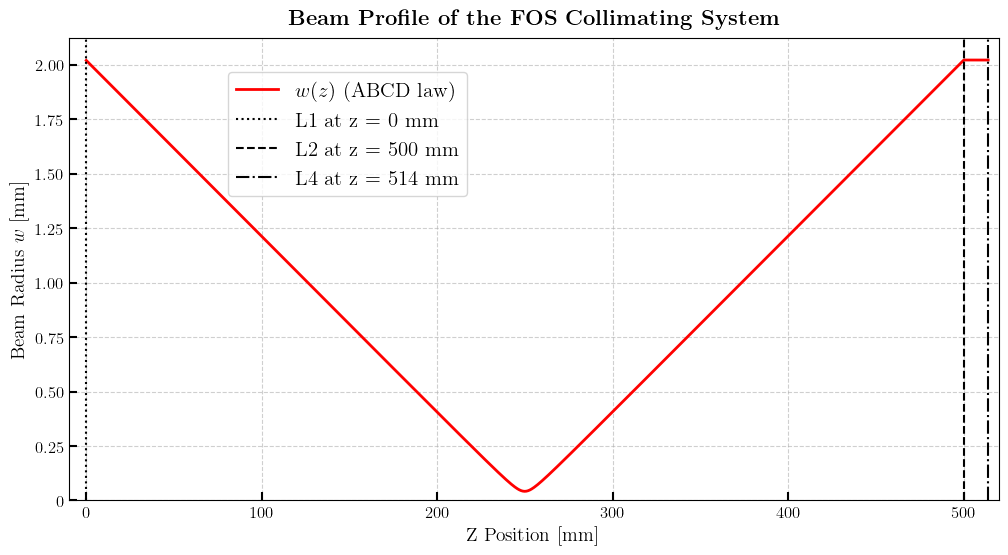


THEORETICAL WAIST SUMMARY
 Min Waist (ABCD law): 41.92 μm at z = 249.75 mm


In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.optimize import curve_fit
from matplotlib.ticker import FuncFormatter

# Set up font properties for CMU Serif
font_path = "/Users/asca/Library/Fonts/cmunrm.ttf"
# Check if the font path exists, otherwise fall back to default settings
if os.path.exists(font_path):
    cmu_serif = fm.FontProperties(fname=font_path)
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Computer Modern']
else:
    print(f"Warning: CMU font not found at {font_path}. Using default Matplotlib settings.")
    plt.rcParams['text.usetex'] = False # Disable LaTeX if font is missing

# Data paths (kept for W0_initial extraction function, though experimental data is not plotted)
data_path1 = "/Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250324/"
data_path_2 = "/Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/LB1471-C" # fig_dir
fig_dir = os.path.join(data_path_2, "fig")
os.makedirs(fig_dir, exist_ok=True)

# --- Updated Constants and Lens Positions ---
focal_length1 = 250.0 # Focal length of L1
focal_length2 = 250.0 # Focal length of L2
z_lens1 = 0.0         # Position of L1
z_lens2 = 500.0       # Position of L2
z_L3_target = 514.0   # Target position for L3 (L4 in the text)

wavelength = 1.064e-3 # wavelength in mm

# --- Custom Y-axis Formatter (NEW) ---
def custom_y_formatter(y, pos):
    """Formats 0 as '0' and all other values as '.2f'."""
    if y == 0:
        return '0'
    return f'{y:.2f}'

# --- Function to get initial beam waist (kept to preserve starting W0 value logic) ---
def get_initial_beam_waist(file_path):
    """Reads the initial beam waist from the specified file."""
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()
        width_x_initial = None
        width_y_initial = None
        found_2nd_moments = False
        
        for i, line in enumerate(lines):
            if "2nd Moments" in line:
                found_2nd_moments = True
            if found_2nd_moments and "Width x" in line:
                # /2 TO CONVERT TO RADIUS AND PLOT THE RADIUS IN THEORETICAL CURVE
                width_x_initial = float(line.split()[2])/2 
            if found_2nd_moments and "Width y" in line:
                # "
                width_y_initial = float(line.split()[2])/2 
        
        if width_x_initial is None or width_y_initial is None:
            print(f"Error: Could not find 'Width x' or 'Width y' in {file_path}. Using default W0_initial = 4 mm.")
            return 4.0
        else:
            print(f"Found beam waist before the lens: Waist x = {width_x_initial} mm, Waist y = {width_y_initial} mm")
            return (width_x_initial + width_y_initial) / 2 # Use average
    except FileNotFoundError:
        print(f"Error: File {file_path} not found. Using default W0_initial = 4 mm.")
        return 4.0
    except Exception as e:
        print(f"Error reading {file_path}: {e}. Using default W0_initial = 4 mm.")
        return 4.0
    
# Read W0_initial from file
before_lens_file = os.path.join(data_path1, "before lens Beam Results.csv")
W0_initial_guess = get_initial_beam_waist(before_lens_file)

# Rayleigh range of initial beam
z_R_initial = np.pi * W0_initial_guess**2 / wavelength 
# Beam parameter at z = 0 (L1 position)
q0 = 0 + 1j * z_R_initial 

# --- ABCD Law Calculation ---

# 1. Apply the first lens transformation at z = z_lens1 (0 mm)
A_lens1 = 1
B_lens1 = 0
C_lens1 = -1 / focal_length1
D_lens1 = 1
q1 = (A_lens1 * q0 + B_lens1) / (C_lens1 * q0 + D_lens1) # Beam parameter just after L1

# 2. Propagate to second lens position (z_lens2 = 500 mm)
z_to_lens2 = z_lens2 - z_lens1
A_free1 = 1
B_free1 = z_to_lens2
C_free1 = 0
D_free1 = 1
q2 = (A_free1 * q1 + B_free1) / (C_free1 * q1 + D_free1) # Beam parameter just before L2

# 3. Second lens transformation at z = z_lens2 (500 mm)
A_lens2 = 1
B_lens2 = 0
C_lens2 = -1 / focal_length2
D_lens2 = 1
q3 = (A_lens2 * q2 + B_lens2) / (C_lens2 * q2 + D_lens2) # Beam parameter just after L2

# --- Theoretical z-values for plotting ---
z_theoretical1 = np.linspace(z_lens1, z_lens2, 1000) # Between L1 and L2
# After L2 (propagate UP TO z_L3_target for visualization) (MODIFIED)
z_theoretical2 = np.linspace(z_lens2, z_L3_target, 2000) 
W_theoretical1 = np.zeros_like(z_theoretical1)
W_theoretical2 = np.zeros_like(z_theoretical2)

# --- Propagate the beam between L1 and L2 ---
for i, z in enumerate(z_theoretical1):
    B_free = z - z_lens1
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q1 + B_free) / (C_free * q1 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < -1e-10:
        W_theoretical1[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical1[i] = np.nan

# --- Propagate the beam after L2 (stopping at L3/L4 position) ---
for i, z in enumerate(z_theoretical2):
    B_free = z - z_lens2
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q3 + B_free) / (C_free * q3 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < -1e-10: 
        W_theoretical2[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical2[i] = np.nan

# Combine theoretical data for plotting
z_theoretical = np.concatenate([z_theoretical1, z_theoretical2])
W_theoretical = np.concatenate([W_theoretical1, W_theoretical2])

# Find theoretical minimum waist and its position
finite_W = W_theoretical[~np.isnan(W_theoretical)]
finite_Z = z_theoretical[~np.isnan(W_theoretical)]
if np.any(np.isfinite(finite_W)):
    min_waist_theo = np.min(finite_W) * 1000
    min_waist_theo_idx = np.argmin(finite_W)
    z_focal_theo = finite_Z[min_waist_theo_idx]
else:
    min_waist_theo = np.nan
    z_focal_theo = np.nan

# --- Plotting ---

plt.figure(figsize=(12, 6))
ax = plt.gca()

# Theoretical curve
plt.plot(z_theoretical, W_theoretical, color='red', linestyle='-', linewidth=2, label=r'$w (z)$ (ABCD law)')

# Vertical lines for lenses
plt.axvline(x=z_lens1, color='k', linestyle=':', label=f'L1 at z = {z_lens1:.0f} mm')
plt.axvline(x=z_lens2, color='k', linestyle='--', label=f'L2 at z = {z_lens2:.0f} mm')
plt.axvline(x=z_L3_target, color='k', linestyle='-.', label=f'L4 at z = {z_L3_target:.0f} mm')

# Theoretical minimum
'''if np.isfinite(min_waist_theo):
    plt.plot(z_focal_theo, min_waist_theo/1000.0,
             'o', mec='red', mfc='none', mew=2, ms=10, label=r'$w_{0,\rm{theo}}$')'''

plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Radius $w$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile of the FOS Collimating System}',
          fontsize=16, fontweight='bold', pad=10)
plt.legend(bbox_to_anchor=(0.16, 0.95), loc='upper left', fontsize=15, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.6)

# Apply custom Y-axis formatter (NEW)
ax.yaxis.set_major_formatter(FuncFormatter(custom_y_formatter))

# Origin at bottom-left
plt.xlim(left=z_lens1 - 10, right=z_lens2 + 20)
plt.ylim(bottom=0)

save_beam_ABCD = os.path.join(fig_dir, "beam_profile_ABCD_FOS_collimating_sys.png")
plt.savefig(save_beam_ABCD, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\nSaved: {save_beam_ABCD}")
plt.show()
plt.close('all')

# Print Theoretical Waist Summary
print("\nTHEORETICAL WAIST SUMMARY")
if np.isfinite(min_waist_theo):
    print(f" Min Waist (ABCD law): {min_waist_theo:.2f} μm at z = {z_focal_theo:.2f} mm")
else:
    print(" No finite theoretical waist found.")